# Random Forests: Presidential Contributions

Let's look at a random forests models for the presidential dataset.

This dataset defines all presidential contribution amounts from publicly available information.

**The purpose here is to try to classify the candidate to whom the contributor likely to contribute.**  

Here are the feature columns we will use:
1. State 
2. Employer
3. Occupation

### Notes

This is going to be a very difficult dataset to get high accuracy, because we don't have any features that are highly correlated with the outcome. Part of our analysis is to see which features prove to be the most useful. 

One might suspect that information like State, might be very predictive -- because presumably New Yorkers might contribute to Hillary Clinton and Texans might contribute to Donald Trump. However, it turns out that State is pretty weakly correlated to the outcome.  

One nice thing about random forests is that since we "bag" featues in differnet trees, we can empirically see which variables have hte most predictive power.  This is helpful for analytical reasons.



In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/tmp/tmpmiwtwmen
	some_property=some_value
Spark UI running on port 4044


## Step 1: Load the data

In [2]:
%%time

# 100k samples
data_file = '/data/presidential_election_contribs/2016/2016-100k.csv.gz'


data = spark.read.csv(data_file, \
                         header=True, inferSchema=True)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.85 s


In [3]:
print("read {:,} records".format(data.count()))

read 100,000 records


In [4]:
data.printSchema()

root
 |-- CMTE_ID: string (nullable = true)
 |-- CAND_ID: string (nullable = true)
 |-- CAND_NM: string (nullable = true)
 |-- CONTBR_NM: string (nullable = true)
 |-- CONTBR_CITY: string (nullable = true)
 |-- CONTBR_ST: string (nullable = true)
 |-- CONTBR_ZIP: string (nullable = true)
 |-- CONTBR_EMPLOYER: string (nullable = true)
 |-- CONTBR_OCCUPATION: string (nullable = true)
 |-- CONTB_RECEIPT_AMT: double (nullable = true)
 |-- CONTB_RECEIPT_DT: string (nullable = true)
 |-- RECEIPT_DESC: string (nullable = true)
 |-- MEMO_CD: string (nullable = true)
 |-- MEMO_TEXT: string (nullable = true)
 |-- FORM_TP: string (nullable = true)
 |-- FILE_NUM: integer (nullable = true)
 |-- TRAN_ID: string (nullable = true)
 |-- ELECTION_TP: string (nullable = true)



In [5]:
## data.show() is hard to read
## use Pandas to pretty print

## vertical
## TODO : 'toPandas'
data.limit(3).toPandas().T

# horizontal
# data.limit(5).toPandas()

,0,1,2
CMTE_ID,C00605568,C00574624,C00580100
CAND_ID,P20002671,P60006111,P80001571
CAND_NM,"Johnson, Gary","Cruz, Rafael Edward 'Ted'","Trump, Donald J."
CONTBR_NM,"SMITH, PAUL","BROWNE, THOMAS JOHN","RISENHOOVER, LINDSEY"
CONTBR_CITY,SAN DIEGO,WHITESBORO,TULSA
CONTBR_ST,CA,NY,OK
CONTBR_ZIP,92117,134921106,74133
CONTBR_EMPLOYER,SELF,RETIRED,INFORMATION REQUESTED
CONTBR_OCCUPATION,RETIRED,RETIRED,INFORMATION REQUESTED
CONTB_RECEIPT_AMT,150,35,73.59


### 1.5 - Sample Data
Start with a small sample of data. Once the algorithm is working procss the full dataset.


In [6]:
## TODO : set sample rate, start with 0.1
# sample size :  10% --> 0.1,   100%  -> 1.0
sample_size = 0.1

data = data.sample(withReplacement=False, fraction=sample_size)
print("sample size {:,} records".format(data.count()))

sample size 9,972 records


## Step 2 : Clean Data

### 2.1 - extract only a few columns

In [7]:
## TODO : Select these columns 
## Hint ; 'CAND_NM', 'CONTBR_ST', 'CONTBR_EMPLOYER', 'CONTBR_OCCUPATION', 'CONTB_RECEIPT_AMT'

columns = ['CAND_NM', 'CONTBR_ST', 'CONTBR_EMPLOYER', 'CONTBR_OCCUPATION', 'CONTB_RECEIPT_AMT']

In [8]:
data2 = data.select(columns)
data2.printSchema()

data2.limit(5).toPandas()

root
 |-- CAND_NM: string (nullable = true)
 |-- CONTBR_ST: string (nullable = true)
 |-- CONTBR_EMPLOYER: string (nullable = true)
 |-- CONTBR_OCCUPATION: string (nullable = true)
 |-- CONTB_RECEIPT_AMT: double (nullable = true)



,CAND_NM,CONTBR_ST,CONTBR_EMPLOYER,CONTBR_OCCUPATION,CONTB_RECEIPT_AMT
0,"Clinton, Hillary Rodham",OR,N/A,RETIRED,56.30
1,"Sanders, Bernard",KS,KCUC,PHYSICIAN,58.65
2,"Trump, Donald J.",OK,DEVON ENERGY,PETROLEUM GEOLOGIST,20.00
3,"Trump, Donald J.",VA,LEIDOS BIOMED.,MANAGER,100.00
4,"Clinton, Hillary Rodham",CA,RETIRED,HUMAN RESOURCE SPECIALIST,150.00


### 2.2 - Clean data (drop null values)

In [9]:
## TODO : drop any null values
## Hint : na
data_clean = data2.na.drop()

print("original data size = {:,}".format(data2.count()) )
print("clean data size = {:,}".format(data_clean.count()) )
print("droped records = {:,}".format(data2.count() - data_clean.count()) )

original data size = 9,972
clean data size = 9,879
droped records = 93


## Step 2 : Basic Exploration

### 2.1 - Print out a contribution count broken down by candidate?

**=> Which candidates got the most donations? (in terms of number of donors)**

In [10]:
## TODO : print out per candidate breakdown
## Hint : group by 'CAND_NM'  and order by 'count'
data_clean.groupBy('CAND_NM').count().orderBy('count', ascending=False).show(20, False)

+-------------------------+-----+
|CAND_NM                  |count|
+-------------------------+-----+
|Clinton, Hillary Rodham  |4622 |
|Sanders, Bernard         |2756 |
|Trump, Donald J.         |1061 |
|Cruz, Rafael Edward 'Ted'|730  |
|Carson, Benjamin S.      |327  |
|Rubio, Marco             |135  |
|Bush, Jeb                |48   |
|Kasich, John R.          |42   |
|Paul, Rand               |32   |
|Fiorina, Carly           |27   |
|Johnson, Gary            |26   |
|Huckabee, Mike           |12   |
|O'Malley, Martin Joseph  |12   |
|Walker, Scott            |12   |
|Christie, Christopher J. |10   |
|Stein, Jill              |9    |
|Graham, Lindsey O.       |5    |
|Santorum, Richard J.     |4    |
|McMullin, Evan           |4    |
|Webb, James Henry Jr.    |2    |
+-------------------------+-----+
only showing top 20 rows



### 2.2 - find min/max/average contribution per candidate

In [14]:
from pyspark.sql.functions import min,max,mean

## TODO : what colum represents contribution amount?
data_clean.groupBy('CAND_NM').\
        agg(min('CONTB_RECEIPT_AMT'), mean('CONTB_RECEIPT_AMT'), max('CONTB_RECEIPT_AMT')).\
        orderBy('CAND_NM').\
        show(40, False)

+-------------------------+----------------------+----------------------+----------------------+
|CAND_NM                  |min(CONTB_RECEIPT_AMT)|avg(CONTB_RECEIPT_AMT)|max(CONTB_RECEIPT_AMT)|
+-------------------------+----------------------+----------------------+----------------------+
|Bush, Jeb                |5.0                   |1533.4375             |5000.0                |
|Carson, Benjamin S.      |-100.0                |124.32449541284404    |5400.0                |
|Christie, Christopher J. |50.0                  |1789.038              |2700.0                |
|Clinton, Hillary Rodham  |-2700.0               |118.56500216356554    |2700.0                |
|Cruz, Rafael Edward 'Ted'|-5380.0               |90.57419178082192     |5400.0                |
|Fiorina, Carly           |13.0                  |122.77777777777777    |1000.0                |
|Graham, Lindsey O.       |-2700.0               |740.0                 |2700.0                |
|Huckabee, Mike           |1.0

### 2.3 - Whoah!  Negative Contributions!
We see some negative contributions!   

**Q==> Can you guys figure out why?**


In [13]:
## TODO Filter out only positive contribs
## Hint : use fileter(condition)
## Hint : condition :   
pos_contribs = data_clean.filter("CONTB_RECEIPT_AMT > 0")

print("original data size = {:,}".format(data_clean.count()) )
print("positive contributions data size = {:,}".format(pos_contribs.count()) )

original data size = 9,879
positive contributions data size = 9,818


### 2.4 - now find min/max/median in positive contributions

In [15]:
from pyspark.sql.functions import min,max,mean

print ("sorted by CAND_NM")

pos_contribs.groupBy('CAND_NM').\
        agg(min('CONTB_RECEIPT_AMT'), mean('CONTB_RECEIPT_AMT'), max('CONTB_RECEIPT_AMT')).\
        orderBy('CAND_NM').\
        show(40, False)

sorted by CAND_NM
+-------------------------+----------------------+----------------------+----------------------+
|CAND_NM                  |min(CONTB_RECEIPT_AMT)|avg(CONTB_RECEIPT_AMT)|max(CONTB_RECEIPT_AMT)|
+-------------------------+----------------------+----------------------+----------------------+
|Bush, Jeb                |5.0                   |1533.4375             |5000.0                |
|Carson, Benjamin S.      |2.0                   |125.5511076923077     |5400.0                |
|Christie, Christopher J. |50.0                  |1789.038              |2700.0                |
|Clinton, Hillary Rodham  |0.64                  |119.48439584235598    |2700.0                |
|Cruz, Rafael Edward 'Ted'|1.0                   |122.02713881019831    |5400.0                |
|Fiorina, Carly           |13.0                  |122.77777777777777    |1000.0                |
|Graham, Lindsey O.       |100.0                 |1600.0                |2700.0                |
|Huckabee, M

In [16]:
from pyspark.sql.functions import min,max,mean

print("sorted by AVG contribution")

pos_contribs.groupBy('CAND_NM').\
        agg(min('CONTB_RECEIPT_AMT'), mean('CONTB_RECEIPT_AMT'), max('CONTB_RECEIPT_AMT')).\
        orderBy('avg(CONTB_RECEIPT_AMT)', ascending=False).\
        show(40, False)

sorted by AVG contribution
+-------------------------+----------------------+----------------------+----------------------+
|CAND_NM                  |min(CONTB_RECEIPT_AMT)|avg(CONTB_RECEIPT_AMT)|max(CONTB_RECEIPT_AMT)|
+-------------------------+----------------------+----------------------+----------------------+
|Christie, Christopher J. |50.0                  |1789.038              |2700.0                |
|Graham, Lindsey O.       |100.0                 |1600.0                |2700.0                |
|Bush, Jeb                |5.0                   |1533.4375             |5000.0                |
|Perry, James R. (Rick)   |1000.0                |1000.0                |1000.0                |
|Walker, Scott            |25.0                  |799.1666666666666     |5400.0                |
|O'Malley, Martin Joseph  |15.0                  |695.0                 |2700.0                |
|Kasich, John R.          |10.0                  |584.4047619047619     |2700.0                |
|Ru

### 2.5 -- Find total contribution amount per candidate

In [17]:
from pyspark.sql.functions import min,max,mean

print("sorted by total contribution")

pos_contribs.groupBy('CAND_NM').\
        sum('CONTB_RECEIPT_AMT').\
        orderBy('sum(CONTB_RECEIPT_AMT)', ascending=False).\
        show(40, False)

sorted by total contribution
+-------------------------+----------------------+
|CAND_NM                  |sum(CONTB_RECEIPT_AMT)|
+-------------------------+----------------------+
|Clinton, Hillary Rodham  |551778.94             |
|Trump, Donald J.         |155589.45999999996    |
|Sanders, Bernard         |124229.92999999993    |
|Cruz, Rafael Edward 'Ted'|86151.16              |
|Bush, Jeb                |73605.0               |
|Rubio, Marco             |59937.0               |
|Carson, Benjamin S.      |40804.11              |
|Kasich, John R.          |24545.0               |
|Christie, Christopher J. |17890.38              |
|Walker, Scott            |9590.0                |
|O'Malley, Martin Joseph  |8340.0                |
|Paul, Rand               |7677.08               |
|Graham, Lindsey O.       |6400.0                |
|Johnson, Gary            |5084.75               |
|Stein, Jill              |4126.0                |
|Fiorina, Carly           |3315.0                |
|H

## Step 3: Build Indexers

In [18]:
from pyspark.ml.feature import StringIndexer

## TODO build indexers for following categorical columns
## CAND_NM,   CONTBR_ST,  CONTBR_EMPLOYER,  CONTBR_OCCUPATION

indexer1 = StringIndexer(inputCol='CAND_NM', outputCol = "CAND_NM_index", handleInvalid="keep")
indexer2 = StringIndexer(inputCol='CONTBR_ST', outputCol = "CONTBR_ST_index", handleInvalid="keep")
indexer3 = StringIndexer(inputCol='CONTBR_EMPLOYER', outputCol = "CONTBR_EMPLOYER_index", handleInvalid="keep")
indexer4 = StringIndexer(inputCol='CONTBR_OCCUPATION', outputCol = "CONTBR_OCCUPATION_index", handleInvalid="keep")


In [19]:
## Stash indexers into 
from pyspark.ml import Pipeline

## TODO : add all indexers into stages
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4])
print(pipeline)

Pipeline_614337aaccd8


In [20]:
%%time
## TODO : fit and transform 'pos_contribs'  through pipeline
indexed_data = pipeline.fit(pos_contribs).transform(pos_contribs)

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 3.27 s


In [21]:
indexed_data.printSchema()
# indexed_data.show()

root
 |-- CAND_NM: string (nullable = true)
 |-- CONTBR_ST: string (nullable = true)
 |-- CONTBR_EMPLOYER: string (nullable = true)
 |-- CONTBR_OCCUPATION: string (nullable = true)
 |-- CONTB_RECEIPT_AMT: double (nullable = true)
 |-- CAND_NM_index: double (nullable = false)
 |-- CONTBR_ST_index: double (nullable = false)
 |-- CONTBR_EMPLOYER_index: double (nullable = false)
 |-- CONTBR_OCCUPATION_index: double (nullable = false)



### 3.1  Understand indexed values

In [22]:
# state
indexed_data.groupBy(['CONTBR_ST', 'CONTBR_ST_index']).count()\
            .orderBy('CONTBR_ST_index', ascending=False).show()

+---------+---------------+-----+
|CONTBR_ST|CONTBR_ST_index|count|
+---------+---------------+-----+
|       XX|           59.0|    1|
|       FF|           58.0|    1|
|       GU|           57.0|    1|
|       ON|           56.0|    1|
|       AP|           55.0|    2|
|       VI|           54.0|    3|
|       AE|           53.0|    7|
|       PR|           52.0|    9|
|       WY|           51.0|   11|
|       SD|           50.0|   11|
|       ND|           49.0|   12|
|       ZZ|           48.0|   15|
|       DE|           47.0|   25|
|       AK|           46.0|   26|
|       MS|           45.0|   27|
|       WV|           44.0|   29|
|       ID|           43.0|   37|
|       RI|           42.0|   38|
|       HI|           41.0|   38|
|       MT|           40.0|   39|
+---------+---------------+-----+
only showing top 20 rows



In [23]:
# employer
indexed_data.groupBy(['CONTBR_EMPLOYER', 'CONTBR_EMPLOYER_index']).count()\
            .orderBy('CONTBR_EMPLOYER_index', ascending=False).show()

+--------------------+---------------------+-----+
|     CONTBR_EMPLOYER|CONTBR_EMPLOYER_index|count|
+--------------------+---------------------+-----+
|NONPROFIT NETWORK...|               4166.0|    1|
|            JOTTA AS|               4165.0|    1|
|LIGHT N LIVELY PO...|               4164.0|    1|
|   PENTA CORPORATION|               4163.0|    1|
|PEOPLES NATIONAL ...|               4162.0|    1|
|HAGLETON AREA SCH...|               4161.0|    1|
|     SUNSET PHARMACY|               4160.0|    1|
|PRESTIGE CONCRETE...|               4159.0|    1|
|DRIVE SMART COLORADO|               4158.0|    1|
|           CHANDLERS|               4157.0|    1|
|      GIBSON GUITARS|               4156.0|    1|
|MADDIN, HAUSER, R...|               4155.0|    1|
|        DISTRICT SUN|               4154.0|    1|
|EPS FIELD SERVICE...|               4153.0|    1|
|EVERETT PUBLIC SC...|               4152.0|    1|
|ENTERTAINMENT PAR...|               4151.0|    1|
|        INTEGRIS OKC|         

In [24]:
# occupation
indexed_data.groupBy(['CONTBR_OCCUPATION', 'CONTBR_OCCUPATION_index']).count()\
            .orderBy('CONTBR_OCCUPATION_index', ascending=False).show(10, False)

+--------------------------------------+-----------------------+-----+
|CONTBR_OCCUPATION                     |CONTBR_OCCUPATION_index|count|
+--------------------------------------+-----------------------+-----+
|SENIOR AIDE                           |2506.0                 |1    |
|FORMERLY MANAGER, INVESTOR AND SHAREHO|2505.0                 |1    |
|GLAZER                                |2504.0                 |1    |
|ORTHODONTIST                          |2503.0                 |1    |
|RESERVATIONS CLERK                    |2502.0                 |1    |
|OWNER/MECHANICAL ENGINEER             |2501.0                 |1    |
|MOBILE APP DEVELOPER                  |2500.0                 |1    |
|TRANPORTATION SUPERVISOR              |2499.0                 |1    |
|DIRECTOR OF LITIGATION SUPPORT        |2498.0                 |1    |
|MORTGAGE SERVICER                     |2497.0                 |1    |
+--------------------------------------+-----------------------+-----+
only s

## Step 4 -  Feature Vectors

In [25]:
from pyspark.ml.feature import VectorAssembler

## Create a feature vector using 'index' columns
feature_columns = ['CONTBR_ST_index', 'CONTBR_EMPLOYER_index', 'CONTBR_OCCUPATION_index' ]

assembler = VectorAssembler(inputCols= feature_columns,  outputCol="features")
feature_vector = assembler.transform(indexed_data)
feature_vector.printSchema()

feature_vector.limit(5).toPandas()

root
 |-- CAND_NM: string (nullable = true)
 |-- CONTBR_ST: string (nullable = true)
 |-- CONTBR_EMPLOYER: string (nullable = true)
 |-- CONTBR_OCCUPATION: string (nullable = true)
 |-- CONTB_RECEIPT_AMT: double (nullable = true)
 |-- CAND_NM_index: double (nullable = false)
 |-- CONTBR_ST_index: double (nullable = false)
 |-- CONTBR_EMPLOYER_index: double (nullable = false)
 |-- CONTBR_OCCUPATION_index: double (nullable = false)
 |-- features: vector (nullable = true)



,CAND_NM,CONTBR_ST,CONTBR_EMPLOYER,CONTBR_OCCUPATION,CONTB_RECEIPT_AMT,CAND_NM_index,CONTBR_ST_index,CONTBR_EMPLOYER_index,CONTBR_OCCUPATION_index,features
0,"Clinton, Hillary Rodham",OR,N/A,RETIRED,56.30,0.0,13.0,0.0,0.0,"[13.0, 0.0, 0.0]"
1,"Sanders, Bernard",KS,KCUC,PHYSICIAN,58.65,1.0,34.0,4099.0,6.0,"[34.0, 4099.0, 6.0]"
2,"Trump, Donald J.",OK,DEVON ENERGY,PETROLEUM GEOLOGIST,20.00,2.0,29.0,2606.0,1844.0,"[29.0, 2606.0, 1844.0]"
3,"Trump, Donald J.",VA,LEIDOS BIOMED.,MANAGER,100.00,2.0,8.0,2125.0,12.0,"[8.0, 2125.0, 12.0]"
4,"Clinton, Hillary Rodham",CA,RETIRED,HUMAN RESOURCE SPECIALIST,150.00,0.0,0.0,1.0,450.0,"[0.0, 1.0, 450.0]"


## Step 5: Split data into training and test


In [26]:
# TODO : Split the data into training and test sets (30% held out for testing)
(training, test) = feature_vector.randomSplit([.7 , .3])

print("training set = " , training.count())
print("testing set = " , test.count())

training set =  6842
testing set =  2976


## Step 6: Create Random Forest Model

In [27]:
from pyspark.ml.classification import RandomForestClassifier

## TODO : Create a random forest model
##        what is the 'labelCol' ?  (Hint : CAND_NM_index)
rf = RandomForestClassifier(labelCol="CAND_NM_index", featuresCol="features", numTrees=20, maxBins=50000)


## 7 -  Train

In [28]:
%%time
print("training starting...")

## TODO : start training, using 'fit' method  on training data
model = rf.fit(training)
print("training done")
print (model)

training starting...
training done
RandomForestClassificationModel (uid=RandomForestClassifier_c3b648464f80) with 20 trees
CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 42.5 s


In [29]:
print("trained on {:,} records".format(training.count()))

trained on 6,842 records


## 8 - Prediction

In [30]:
%%time

## TODO : predict on 'test' columns
##        use 'transform' method
predictions = model.transform(test)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 80.4 ms


In [31]:
print("predicted on {:,} records".format(test.count()))

predicted on 2,976 records


In [32]:
# Select example rows to display.
predictions.sample(False, 0.1).select("prediction", 'CAND_NM_index', "CAND_NM").show()

+----------+-------------+--------------------+
|prediction|CAND_NM_index|             CAND_NM|
+----------+-------------+--------------------+
|       0.0|          6.0|           Bush, Jeb|
|       3.0|          4.0| Carson, Benjamin S.|
|       2.0|          4.0| Carson, Benjamin S.|
|       0.0|          4.0| Carson, Benjamin S.|
|       2.0|          4.0| Carson, Benjamin S.|
|       2.0|          4.0| Carson, Benjamin S.|
|       2.0|          4.0| Carson, Benjamin S.|
|       2.0|          4.0| Carson, Benjamin S.|
|       2.0|          4.0| Carson, Benjamin S.|
|       0.0|          0.0|Clinton, Hillary ...|
|       0.0|          0.0|Clinton, Hillary ...|
|       2.0|          0.0|Clinton, Hillary ...|
|       0.0|          0.0|Clinton, Hillary ...|
|       0.0|          0.0|Clinton, Hillary ...|
|       2.0|          0.0|Clinton, Hillary ...|
|       2.0|          0.0|Clinton, Hillary ...|
|       2.0|          0.0|Clinton, Hillary ...|
|       0.0|          0.0|Clinton, Hilla

## 9 - Evaluate

In [33]:
predictions_test = model.transform(test)
predictions_train = model.transform(training)

### 9.1 - Acuracy
**=> TODO: Think about the test error here?  Does it seem high?  What does that say about our model?**

**=> How do we define model success?**

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="CAND_NM_index", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.6505407775504238
Test set accuracy =  0.5053763440860215


### 9.2 - Confusion Matrix

####  Figure Out Candidate Mapping

In [35]:
## Candidate Mapping
candidate_mapping = indexed_data.groupBy(['CAND_NM', 'CAND_NM_index']).count()
# candidate_mapping.orderBy('CAND_NM').show()
candidate_mapping.orderBy('CAND_NM_index').show()

+--------------------+-------------+-----+
|             CAND_NM|CAND_NM_index|count|
+--------------------+-------------+-----+
|Clinton, Hillary ...|          0.0| 4618|
|    Sanders, Bernard|          1.0| 2755|
|    Trump, Donald J.|          2.0| 1039|
|Cruz, Rafael Edwa...|          3.0|  706|
| Carson, Benjamin S.|          4.0|  325|
|        Rubio, Marco|          5.0|  129|
|           Bush, Jeb|          6.0|   48|
|     Kasich, John R.|          7.0|   42|
|          Paul, Rand|          8.0|   32|
|      Fiorina, Carly|          9.0|   27|
|       Johnson, Gary|         10.0|   26|
|       Walker, Scott|         11.0|   12|
|O'Malley, Martin ...|         12.0|   12|
|      Huckabee, Mike|         13.0|   12|
|Christie, Christo...|         14.0|   10|
|         Stein, Jill|         15.0|    9|
|  Graham, Lindsey O.|         16.0|    4|
|      McMullin, Evan|         17.0|    4|
|Santorum, Richard J.|         18.0|    3|
|Webb, James Henry...|         19.0|    2|
+----------

#### Confusion Matrix

**=>What can you conclude from the confusion matrix?**

Use the list above to interpret the label.  

Is our model better at predicting candidates with many donations (Clinton, Sanders), or few donations?

What can you say about our model perfromance.

In [36]:
cm = predictions.groupBy('CAND_NM').pivot('prediction', range(0,22)).count().na.fill(0).orderBy('CAND_NM')
cm.toPandas()

,CAND_NM,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,"Bush, Jeb",6,2,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Carson, Benjamin S.",7,16,67,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Christie, Christopher J.",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Clinton, Hillary Rodham",792,112,463,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Cruz, Rafael Edward 'Ted'",28,43,139,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Fiorina, Carly",1,2,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Graham, Lindsey O.",1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Huckabee, Mike",3,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Johnson, Gary",3,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Kasich, John R.",5,1,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Step 10 -  Print the feature importanes

**=> TODO Compare the relative weight of the feature importances?**

In [37]:
import pandas as pd

imp = model.featureImportances.toArray()
print(imp)
df = pd.DataFrame({'cols': feature_columns, 'importance':imp})
print(df)
df.sort_values(by=['importance'], ascending=False)

[0.03339745 0.63959505 0.32700749]
                      cols  importance
0          CONTBR_ST_index    0.033397
1    CONTBR_EMPLOYER_index    0.639595
2  CONTBR_OCCUPATION_index    0.327007


,cols,importance
1,CONTBR_EMPLOYER_index,0.639595
2,CONTBR_OCCUPATION_index,0.327007
0,CONTBR_ST_index,0.033397


## Conclusion: Most important Fields

1. Employer
2. Occupation
3. State

Other fields not significant

**=> TODO Compare the relative weight of the feature importances?**

**=> BONUS: Do a Pearson Correlation Matrix of the variables to the outcome, to see correlation**



[]

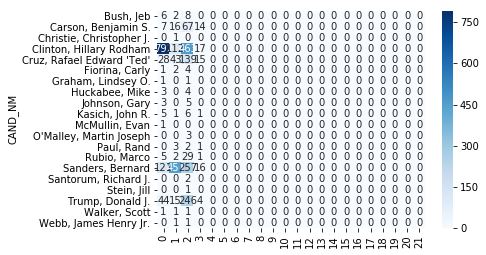

In [39]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("CAND_NM", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True,  fmt=',', cmap="Blues").plot()

## BONUS : Running on full dataset

**Use the dowload script**

```bash
$ cd   ~/data/presidential_election_contribs
$ ./download-data.sh
```

This will download full dataset.

As we run on larger dataset, the execution will take longer and Jupyter notebook might time out.  So let's run this in command line / script mode

Download the Jupyter notebook as Python file (File --> Download as --> Python)

```bash
# run the downloaded python script as follows
$    time  ~/spark/bin/spark-submit    --master local[*]  random-forest-2-election-classification.py 2> logs

```

Watch the output
